# Brawlhalla Legends Analysis

## 1 - Importing the libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from datetime import datetime
from sklearn.linear_model import LinearRegression

## 2 - Reading and visualizing data

In [2]:
champions = pd.read_csv('../input/brawlhalla-legends/data.csv', index_col = 0)
champions.shape

(55, 7)

In [3]:
champions.head(10)

,strength,dexterity,defence,speed,gender,price,datereleased
name,,,,,,,
Ada,6,7,3,6,Female,3900,12.11.2014
Arcadia,7,7,4,4,Female,5400,16.3.2022
Artemis,5,5,4,8,Female,5400,14.6.2017
Asuri,4,7,5,6,Female,3900,24.9.2015
Azoth,7,5,6,4,Male,5400,6.1.2016
Barraza,6,4,8,4,Male,3900,20.10.2015
Bödvar,6,6,5,5,Male,900,30.4.2014
Brynn,5,5,5,7,Female,900,6.8.2015
Caspian,7,5,4,6,Male,5400,26.7.2017


In [4]:
champions.tail(10)

,strength,dexterity,defence,speed,gender,price,datereleased
name,,,,,,,
Thor,6,4,7,5,Male,5400,14.3.2019
Ulgrim,6,3,7,6,Male,5400,2.3.2016
Val,4,5,6,7,Female,5400,24.8.2016
Vector,5,4,6,7,Male,5400,20.9.2019
Volkov,4,8,6,4,Male,5400,18.12.2019
Lord Vraxx,4,8,4,6,Male,2300,30.4.2014
Wu Shang,5,7,5,5,Male,5400,13.7.2016
Xull,9,4,5,4,Male,5400,22.11.2017
Yumiko,4,7,4,7,Female,5400,3.5.2017


## 3 - Getting top 5 legends based on meta

In [5]:
mask = (champions.defence > 5) & (champions.speed > 5) & (champions.dexterity >= 5)
champions[mask]

,strength,dexterity,defence,speed,gender,price,datereleased
name,,,,,,,
Lucien,3,5,6,8,Male,2300,9.1.2015
Nix,4,5,7,6,Female,5400,15.2.2017
Orion,4,6,6,6,Male,2300,30.4.2014
Rayman,5,5,6,6,Male,5400,6.11.2018
Val,4,5,6,7,Female,5400,24.8.2016


### On the meta, the most valuable status are Defence and Speed, with Dexterity also being a good attribute.

#### Comparing the table above with the Community Tier List (06 Jul. 2022)

P.S.: Legend's position at the tier list depends not only on base stats, but also weapons and sigs

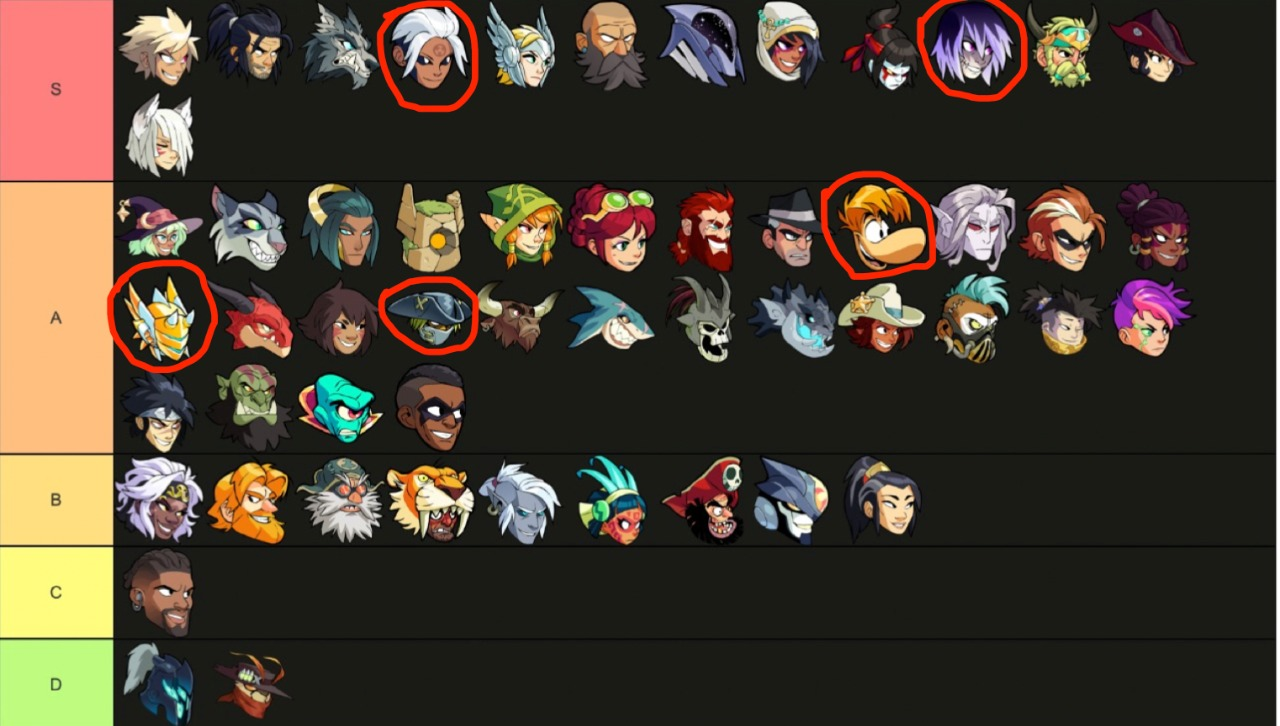

## 4 - Predicting next 3 legend's number of days to launch

### 4.1 - Calculating number of days a new legend is launched after the one before him/her

In [6]:
champions['datereleased'] = pd.to_datetime(champions['datereleased'], infer_datetime_format=True)
champions['gender'].replace(['Female','Male', '???'], [0,1,0.5] ,inplace=True)
champions = champions.sort_values(by = ['datereleased'])
champions['lauch_time_from_previous'] = champions['datereleased'].diff() / np.timedelta64(1, 'D')
champions.iloc[0:1,7] = 0.0
champions.head()

,strength,dexterity,defence,speed,gender,price,datereleased,lauch_time_from_previous
name,,,,,,,,
Orion,4,6,6,6,1.0,2300,2014-04-30,0.0
Bödvar,6,6,5,5,1.0,900,2014-04-30,0.0
Cassidy,6,8,4,4,0.0,2300,2014-04-30,0.0
Lord Vraxx,4,8,4,6,1.0,2300,2014-04-30,0.0
Gnash,7,3,5,7,1.0,2300,2014-05-22,22.0


In [7]:
mask = champions['datereleased'] >= datetime.strptime('01/11/15', '%d/%m/%y')
champions_after_open_beta = champions[mask]
champions_after_open_beta.head()

,strength,dexterity,defence,speed,gender,price,datereleased,lauch_time_from_previous
name,,,,,,,,
Ember,6,6,3,7,0.0,900,2015-11-11,22.0
Kor,6,5,7,4,1.0,3900,2016-01-06,56.0
Ulgrim,6,3,7,6,1.0,5400,2016-02-03,28.0
Diana,5,6,5,6,0.0,5400,2016-03-30,56.0
Koji,5,8,4,5,1.0,5400,2016-04-02,3.0


In [8]:
mask = champions['datereleased'] >= datetime.strptime('17/10/17', '%d/%m/%y')
champions_after_launch = champions[mask]
champions_after_launch.head()

,strength,dexterity,defence,speed,gender,price,datereleased,lauch_time_from_previous
name,,,,,,,,
Sidra,6,4,6,6,0.0,3900,2017-10-19,85.0
Mirage,7,6,4,5,0.0,3900,2017-11-01,13.0
Xull,9,4,5,4,1.0,5400,2017-11-22,21.0
Jiro,5,7,3,7,1.0,5400,2018-04-18,147.0
Lin Fei,3,8,4,7,0.0,5400,2018-05-30,42.0


### 4.2 - Getting vectors to use at the linear regression

In [9]:
def get_value_array_and_indexes(dataframe, column):
    dataframe_values = np.array(dataframe[column]).reshape(-1,1)
    dataframe_indexes = np.array(range(dataframe_values.shape[0])).reshape(-1, 1)
    return [dataframe_values, dataframe_indexes]

#### 4.2.1 - Alpha Release

In [10]:
alpha_predict, alpha_indexes = get_value_array_and_indexes(champions, 'lauch_time_from_previous')    

In [11]:
alpha_predict

array([[  0.],
       [  0.],
       [  0.],
       [  0.],
       [ 22.],
       [ 96.],
       [  0.],
       [ 42.],
       [ 49.],
       [ 16.],
       [  0.],
       [  0.],
       [179.],
       [ 85.],
       [ 23.],
       [ 10.],
       [ 16.],
       [ 22.],
       [ 56.],
       [ 28.],
       [ 56.],
       [  3.],
       [ 25.],
       [ 35.],
       [ 42.],
       [ 42.],
       [ 35.],
       [ 49.],
       [ 91.],
       [ 18.],
       [ 24.],
       [ 77.],
       [ 42.],
       [ 85.],
       [ 13.],
       [ 21.],
       [147.],
       [ 42.],
       [ 12.],
       [ 22.],
       [ 22.],
       [ 68.],
       [ 58.],
       [ 63.],
       [ 43.],
       [104.],
       [ 86.],
       [ 89.],
       [ 23.],
       [ 66.],
       [144.],
       [160.],
       [ 90.],
       [182.],
       [154.]])

In [12]:
alpha_indexes

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40],
       [41],
       [42],
       [43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54]])

#### 4.2.2 - Open Beta

In [13]:
beta_predict, beta_indexes = get_value_array_and_indexes(champions_after_open_beta, 'lauch_time_from_previous')

In [14]:
beta_predict

array([[ 22.],
       [ 56.],
       [ 28.],
       [ 56.],
       [  3.],
       [ 25.],
       [ 35.],
       [ 42.],
       [ 42.],
       [ 35.],
       [ 49.],
       [ 91.],
       [ 18.],
       [ 24.],
       [ 77.],
       [ 42.],
       [ 85.],
       [ 13.],
       [ 21.],
       [147.],
       [ 42.],
       [ 12.],
       [ 22.],
       [ 22.],
       [ 68.],
       [ 58.],
       [ 63.],
       [ 43.],
       [104.],
       [ 86.],
       [ 89.],
       [ 23.],
       [ 66.],
       [144.],
       [160.],
       [ 90.],
       [182.],
       [154.]])

In [15]:
beta_indexes

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37]])

#### 4.2.3 - Launch

In [16]:
launch_predict, launch_indexes = get_value_array_and_indexes(champions_after_launch, 'lauch_time_from_previous')

In [17]:
launch_predict

array([[ 85.],
       [ 13.],
       [ 21.],
       [147.],
       [ 42.],
       [ 12.],
       [ 22.],
       [ 22.],
       [ 68.],
       [ 58.],
       [ 63.],
       [ 43.],
       [104.],
       [ 86.],
       [ 89.],
       [ 23.],
       [ 66.],
       [144.],
       [160.],
       [ 90.],
       [182.],
       [154.]])

In [18]:
launch_indexes

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21]])

## 4.3 - Linear Regression and prediction of the next 3 legends launch

### 4.3.1 - Including all legends

In [19]:
alpha_regression = LinearRegression()
alpha_regression.fit(alpha_indexes, alpha_predict)

LinearRegression()

In [20]:
to_predict_launch_dates_index_alpha = [55,56,57]
to_predict_launch_dates_index_alpha = np.array(to_predict_launch_dates_index_alpha).reshape(-1,1)

In [21]:
predicted_launch_times = alpha_regression.predict(to_predict_launch_dates_index_alpha)
m_alpha = alpha_regression.coef_
c_alpha = alpha_regression.intercept_
print("Predicted Launch times:\n", predicted_launch_times)

Predicted Launch times:
 [[96.69292929]
 [98.27806638]
 [99.86320346]]


#### Plotting

In [22]:
def plot_graph(title, x_label, y_label, dataframe, column):
    %matplotlib inline
    f = plt.figure(figsize=(8, 4))
    plt.title(title)  
    plt.xlabel(x_label)  
    plt.ylabel(y_label) 
    plt.scatter(dataframe.index, dataframe[column], color="black")
    plt.plot(dataframe.index, dataframe[column], color="blue", linewidth=3)
    plt.xticks(())
    plt.show()
    

In [23]:
def plot_regression_data(title, x_label, y_label, dataframe, regression_column, coeficient, intercept, train_indexes, predicted_indexes, scale, confidence_interval):
    %matplotlib inline
    f = plt.figure(figsize=(8, 4))
    plt.title(title)  
    plt.xlabel(x_label)  
    plt.ylabel(y_label) 
    plt.scatter(dataframe.index, dataframe[regression_column], color="black")
    plt.plot(dataframe.index, dataframe[regression_column], color="blue", linewidth=3)
    plt.xticks(())
    ax = plt.gca()
    ax.axes.yaxis.set_ticklabels([])
    new_y = [coeficient * i + intercept for i in np.append(train_indexes, predicted_indexes)]
    new_y = np.array(new_y).reshape(-1)
    plt.plot(np.append(train_indexes, predicted_indexes),new_y,color="red", linewidth=3)
    ax.fill_between(np.append(train_indexes, predicted_indexes), (new_y-confidence_interval[0]), (new_y+confidence_interval[1]), color='red', alpha=.1)
    plt.yscale(scale)
    plt.yticks(())
    plt.show()
    

In [24]:
confidence_interval_alpha = st.norm.interval(alpha=0.95,
                 loc=np.mean(champions['lauch_time_from_previous']),
                 scale=st.sem(alpha_predict))
confidence_interval_alpha

(array([39.5620555]), array([65.05612632]))

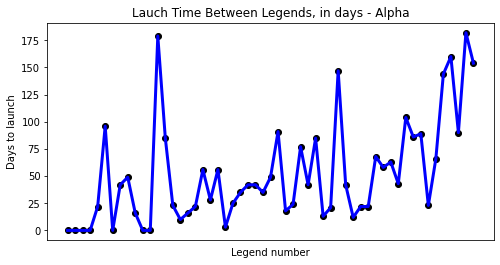

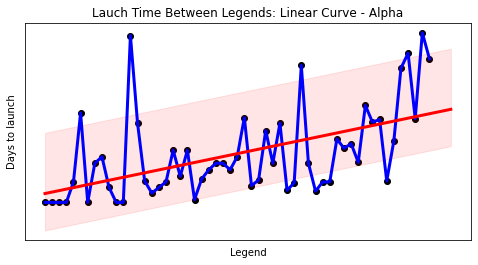

In [25]:
plot_graph('Lauch Time Between Legends, in days - Alpha', 'Legend number', 'Days to launch', champions, 'lauch_time_from_previous')
plot_regression_data('Lauch Time Between Legends: Linear Curve - Alpha', 'Legend', 'Days to launch', champions, 'lauch_time_from_previous', m_alpha, c_alpha, alpha_indexes, to_predict_launch_dates_index_alpha, "linear", confidence_interval_alpha)

### 4.3.2 - Only with legends after Open Beta Release

In [26]:
beta_regression = LinearRegression()
beta_regression.fit(beta_indexes, beta_predict)

LinearRegression()

In [27]:
to_predict_launch_dates_index_beta = [38,39,40]
to_predict_launch_dates_index_beta = np.array(to_predict_launch_dates_index_beta).reshape(-1,1)

In [28]:
predicted_launch_times_beta = beta_regression.predict(to_predict_launch_dates_index_beta)
m_beta = beta_regression.coef_
c_beta = beta_regression.intercept_
print("Predicted Launch times:\n", predicted_launch_times_beta)

Predicted Launch times:
 [[109.49928876]
 [111.95809169]
 [114.41689463]]


In [29]:
confidence_interval = st.norm.interval(alpha=0.95,
                 loc=np.mean(champions_after_open_beta['lauch_time_from_previous']),
                 scale=st.sem(beta_predict))
confidence_interval

(array([46.96598162]), array([76.13928154]))

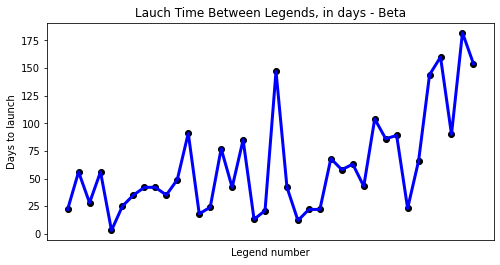

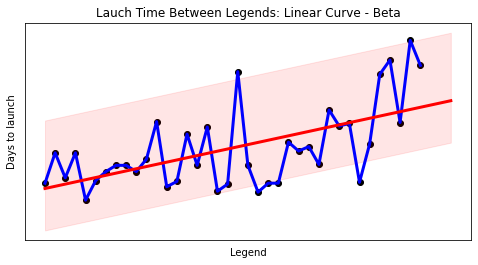

In [30]:
plot_graph('Lauch Time Between Legends, in days - Beta', 'Legend number', 'Days to launch', champions_after_open_beta, 'lauch_time_from_previous')
plot_regression_data('Lauch Time Between Legends: Linear Curve - Beta', 'Legend', 'Days to launch', champions_after_open_beta, 'lauch_time_from_previous', m_beta, c_beta, beta_indexes, to_predict_launch_dates_index_beta, "linear", confidence_interval)

### 4.3.3 - Only with legends after Final Release

In [31]:
launch_regression = LinearRegression()
launch_regression.fit(launch_indexes, launch_predict)

LinearRegression()

In [32]:
to_predict_launch_dates_index_final = [22,23,24]
to_predict_launch_dates_index_final = np.array(to_predict_launch_dates_index_final).reshape(-1,1)

In [33]:
predicted_launch_times_final = launch_regression.predict(to_predict_launch_dates_index_final)
m_launch = launch_regression.coef_
c_launch = launch_regression.intercept_
print("Predicted Launch times:\n", predicted_launch_times_final)

Predicted Launch times:
 [[133.06493506]
 [137.94014681]
 [142.81535855]]


In [34]:
confidence_interval_launch = st.t.interval(alpha=0.95, df=len(champions_after_launch['lauch_time_from_previous'])-1,
              loc=np.mean(champions_after_launch['lauch_time_from_previous']),
              scale=st.sem(launch_predict))
confidence_interval_launch

(array([53.70255431]), array([100.29744569]))

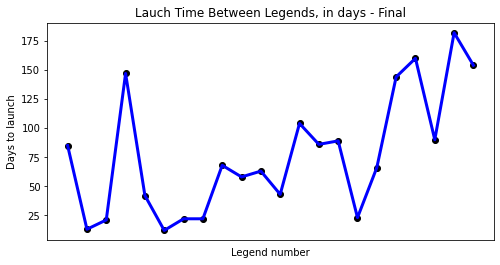

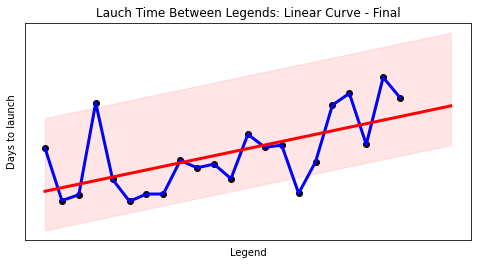

In [35]:
plot_graph('Lauch Time Between Legends, in days - Final', 'Legend number', 'Days to launch', champions_after_launch, 'lauch_time_from_previous')
plot_regression_data('Lauch Time Between Legends: Linear Curve - Final', 'Legend', 'Days to launch', champions_after_launch, 'lauch_time_from_previous', m_launch, c_launch, launch_indexes, to_predict_launch_dates_index_final, "linear", confidence_interval_launch)

## 4.4 - Log Regression and prediction of the next 3 legends launch

In [36]:
def get_log_array_indexes_and_fit(dataset):
    log_array = np.array(dataset)
    log_indexes = np.log(np.arange(1, dataset.shape[0]+1, 1))
    log_fit = np.polyfit(log_indexes, log_array, 1)
    return [log_array, log_indexes, log_fit]

In [37]:
def get_prediction_indexes_list(dataset, number_of_predictions):
    aux = 1
    list_of_future_indexes = []
    while (aux <= number_of_predictions):
        list_of_future_indexes.append(dataset.shape[0]+aux)
        aux += 1
    return list_of_future_indexes

### 4.4.1 - Including all legends

In [38]:
alpha_log_array, alpha_log_indexes, alpha_log_fit = get_log_array_indexes_and_fit(alpha_predict)
alpha_log_fit

array([[ 24.38223053],
       [-22.31270146]])

In [39]:
to_predict_launch_dates_index_alpha = get_prediction_indexes_list(alpha_predict, 3) # [champions.shape[0]+1, champions.shape[0]+2, champions.shape[0]+3]
to_predict_launch_dates_index_alpha = np.log(to_predict_launch_dates_index_alpha)
to_predict_launch_dates_index_alpha

array([4.02535169, 4.04305127, 4.06044301])

In [40]:
predicted_launch_times = alpha_log_fit[1] + alpha_log_fit[0] * to_predict_launch_dates_index_alpha
predicted_launch_times

array([75.83435145, 76.26590662, 76.6899561 ])

In [41]:
confidence_interval_alpha = st.norm.interval(alpha=0.95,
                 loc=np.mean(champions['lauch_time_from_previous']),
                 scale=st.sem(alpha_predict))
confidence_interval_alpha

(array([39.5620555]), array([65.05612632]))

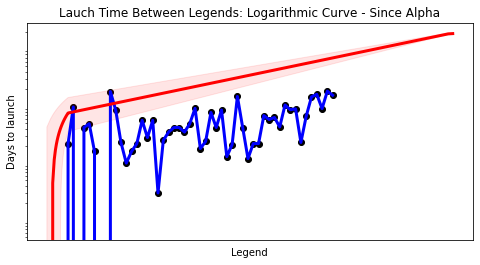

In [42]:
plot_regression_data('Lauch Time Between Legends: Logarithmic Curve - Since Alpha', 'Legend', 'Days to launch', champions, 'lauch_time_from_previous', alpha_log_fit[0], alpha_log_fit[1], alpha_log_indexes, predicted_launch_times, "log", confidence_interval_alpha)

### 4.4.2 - Including only since beta launch date

In [43]:
beta_log_array, beta_log_indexes, beta_log_fit = get_log_array_indexes_and_fit(beta_predict)
beta_log_fit

array([[24.44642158],
       [-4.68957877]])

In [44]:
to_predict_launch_dates_index_beta = get_prediction_indexes_list(beta_predict, 3) # [champions.shape[0]+1, champions.shape[0]+2, champions.shape[0]+3]
to_predict_launch_dates_index_beta = np.log(to_predict_launch_dates_index_beta)
to_predict_launch_dates_index_beta

array([3.66356165, 3.68887945, 3.71357207])

In [45]:
predicted_launch_times = beta_log_fit[1] + beta_log_fit[0] * to_predict_launch_dates_index_beta
predicted_launch_times

array([84.87139374, 85.49032354, 86.09396956])

In [46]:
confidence_interval = st.norm.interval(alpha=0.95,
                 loc=np.mean(champions_after_open_beta['lauch_time_from_previous']),
                 scale=st.sem(beta_predict))
confidence_interval

(array([46.96598162]), array([76.13928154]))

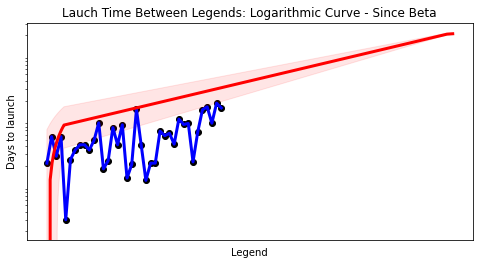

In [47]:
plot_regression_data('Lauch Time Between Legends: Logarithmic Curve - Since Beta', 'Legend', 'Days to launch', champions_after_open_beta, 'lauch_time_from_previous', beta_log_fit[0], beta_log_fit[1], beta_log_indexes, predicted_launch_times, "log", confidence_interval)

### 4.4.3 - Including only since final launch date

In [48]:
launch_log_array, launch_log_indexes, launch_log_fit = get_log_array_indexes_and_fit(launch_predict)
launch_log_fit

array([[27.80388959],
       [15.74148297]])

In [49]:
to_predict_launch_dates_index_final = get_prediction_indexes_list(launch_predict, 3) # [champions.shape[0]+1, champions.shape[0]+2, champions.shape[0]+3]
to_predict_launch_dates_index_final = np.log(to_predict_launch_dates_index_final)
to_predict_launch_dates_index_final

array([3.13549422, 3.17805383, 3.21887582])

In [50]:
predicted_launch_times = launch_log_fit[1] + launch_log_fit[0] * to_predict_launch_dates_index_final
predicted_launch_times

array([102.92041796, 104.10374078, 105.23875101])

In [51]:
confidence_interval_launch = st.t.interval(alpha=0.95, df=len(champions_after_launch['lauch_time_from_previous'])-1,
              loc=np.mean(champions_after_launch['lauch_time_from_previous']),
              scale=st.sem(launch_predict))
confidence_interval_launch

(array([53.70255431]), array([100.29744569]))

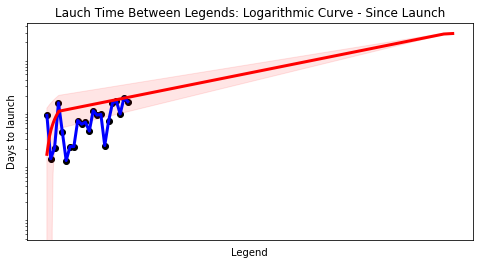

In [52]:
plot_regression_data('Lauch Time Between Legends: Logarithmic Curve - Since Launch', 'Legend', 'Days to launch', champions_after_launch, 'lauch_time_from_previous', launch_log_fit[0], launch_log_fit[1], launch_log_indexes, predicted_launch_times, "log", confidence_interval_launch)

## 5 - Correlation Matrix

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


,strength,dexterity,defence,speed,gender,price,lauch_time_from_previous
strength,1.00,-0.43,-0.14,-0.39,0.04,0.05,-0.12
dexterity,-0.43,1.00,-0.51,-0.06,-0.10,-0.03,-0.06
defence,-0.14,-0.51,1.00,-0.46,0.26,0.03,0.03
speed,-0.39,-0.06,-0.46,1.00,-0.24,-0.06,0.15
gender,0.04,-0.10,0.26,-0.24,1.00,0.02,-0.12
price,0.05,-0.03,0.03,-0.06,0.02,1.00,0.23
lauch_time_from_previous,-0.12,-0.06,0.03,0.15,-0.12,0.23,1.00


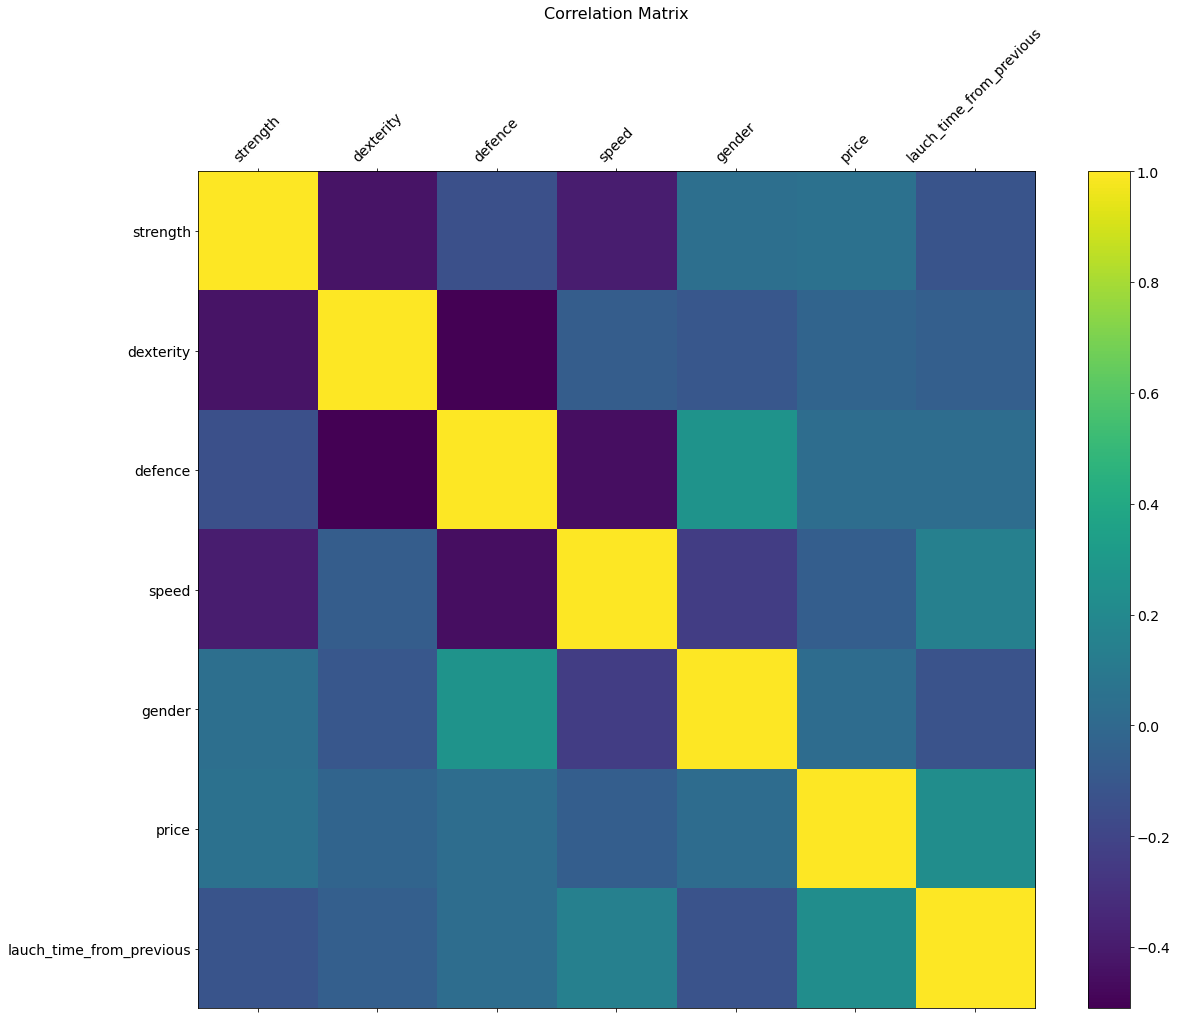

In [53]:
f = plt.figure(figsize=(19, 15))
plt.matshow(champions.corr(), fignum=f.number)
plt.xticks(range(champions.select_dtypes(['number']).shape[1]), champions.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(champions.select_dtypes(['number']).shape[1]), champions.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
champions.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

## 6 - Male and Female probabilities

In [54]:
male_champions = len(champions[champions.gender == 1.0])
total_champions = len(champions)
male_probability = male_champions / (total_champions - 2)
male_probability

0.5471698113207547

In [55]:
female_champions = len(champions[champions.gender == 0.0])
female_probability = female_champions / (total_champions - 2)
female_probability

0.4528301886792453

## 7 - Conclusion

1 - Legends with the most speed, defence and dexterity usually are considered the best by the community;

2 - Male legends usually have higher defence and lower speed;

3 - It's most likely to a legend with '???' gender be male;

4 - The way which launch time of future legends are described varies with the period of the game (alpha, beta and final launches);

5 - The way that the launch time of legends varies (for now) is, most likely, linearly;

6 - The next champion should launch around 133 days, but it could vary, since the launch dates doesn't follow a definitive pattern;

7 - High speed and dexterity usually means low defence and strength;

8 - High speed usually means low defence and strength;

9 - Legend's prices had grown over time.